María Ángeles Magro Garrote (100472867)

Ángela María Durán Pinto (100472766)

Marina Gómez Rey (100472836)


In [ ]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch import optim
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal as mvn
from matplotlib import cm
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# Step 1: Define the VAE components

class encoder(nn.Module):
    def __init__(self, dimz, dimension, var_x=0.1):
        super().__init__()

        self.dimz = dimz  # dimz is k, the dimension of the latent space
        self.dimension = dimension

        # Define dense layers
        self.fc1 = nn.Linear(in_features=dimension, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=32)
        self.fc5 = nn.Linear(in_features=32, out_features=256)
        self.fc_mu_var = nn.Linear(in_features=256, out_features=dimz * 2)

        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, x):
        # The forward method to project and image into a 2dimz dimensional vector

        z = self.relu(self.fc1(x))
        z = self.relu(self.fc2(z))
        z = self.relu(self.fc3(z))
        z = self.relu(self.fc4(z))
        z = self.relu(self.fc5(z))
        z = self.fc_mu_var(z)

        return z


    def encode_and_sample(self, x, flag_sample=True):
        # This method computes both the posterior mean and variance
        # Also we obtain a sample from the posterior using the
        # reparameterization trick.

        # We obtain the encoder projection using the forward method
        z = self.forward(x)

        # The mean is the first dimz components of the forward output
        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        # soft plus
        var = self.softplus(0.5 * z[:, self.dimz:])

        sample = None

        if flag_sample:
            eps = torch.randn_like(var)
            sample = mu + eps * (var ** 0.5)

        return mu, var, sample

class decoder(nn.Module):
    def __init__(self, dimz, dimension, var_x=0.1):
        super().__init__()

        self.dimz = dimz
        self.dimension = dimension

        # Define dense layers
        self.fc1 = nn.Linear(in_features=dimz, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=32)
        self.fc6 = nn.Linear(in_features=32, out_features=dimension)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # The forward method to reconstruct data from the latent space

        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))
        # tanh

        return x


    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)
class VAE(nn.Module):
    def __init__(self, dimz, input_dim=3):
        super().__init__()

        self.dimz = dimz

        self.encoder = encoder(dimz, input_dim)
        self.decoder = decoder(dimz, input_dim)

    def forward(self, x):
        mu_z, var_z, sample_z = self.encoder.encode_and_sample(x)
        recon_x = self.decoder.decode(sample_z)
        return recon_x, mu_z, var_z

    def loss_function(self, x, recon_x, mu_z, var_z):
        recon_loss = torch.mean((x - recon_x)**2)

        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        return recon_loss + kl_loss, recon_loss, kl_loss

class VAE_extended(VAE):
    def __init__(self, dimz=2, input_dim=3, lr=1e-3, epochs=10, save_folder='./', restore=False):
        super().__init__(dimz, input_dim)

        self.lr = lr
        self.epochs = epochs
        self.save_folder = save_folder
        self.restore = restore

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, data_tensor, batch_size=32):
        self.train()

        num_batches = len(data_tensor) // batch_size

        for e in range(int(self.epochs)):
            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            for i in range(0, len(data_tensor), batch_size):
                batch = data_tensor[i:i+batch_size].to(self.device)

                self.optim.zero_grad()

                recon_x, mu_z, var_z = self.forward(batch)

                loss, rec, kl_l = self.loss_function(batch, recon_x, mu_z, var_z)

                loss.backward()

                self.optim.step()

                train_loss += loss.item() * len(batch)
                train_rec += rec.item() * len(batch)
                train_kl_l += kl_l.item() * len(batch)

            self.loss_during_training.append(train_loss / len(data_tensor))
            self.reconstruc_during_training.append(train_rec / len(data_tensor))
            self.KL_during_training.append(train_kl_l / len(data_tensor))

            if e % 1 == 0:
                torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
                print('Train Epoch: {} \tLoss: {:.6f}'.format(e, self.loss_during_training[-1]))


    def sample(self, num_samples):
        with torch.no_grad():
            eps = torch.randn([num_samples, self.dimz]).to(self.device)
            x_sample = self.decoder.decode(eps)
            return x_sample.to("cpu").detach()

        plt.figure(figsize=(10, 6))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='VAE Samples')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.title('VAE Samples vs Ground Truth Distribution')
        plt.legend()
        plt.show()

    def compare_clusters(self, data):
        # Get latent space representations of ground truth data
        with torch.no_grad():
            mu = self.encoder(data)

        # Find the optimal number of clusters for synthetic data
        best_score = -1
        optimal_num_clusters = 0

        # Try different numbers of clusters
        for num_components in range(2, 11):  # Assuming a maximum of 10 clusters
            # Perform K-means clustering on VAE latent space representations
            kmeans_vae = KMeans(n_clusters=num_components, random_state=42)
            clusters_vae = kmeans_vae.fit_predict(mu.numpy())

            # Calculate silhouette score
            score = silhouette_score(mu.numpy(), clusters_vae)

            # Update optimal number of clusters if silhouette score is higher
            if score > best_score:
                best_score = score
                optimal_num_clusters = num_components

        # Perform K-means clustering on ground truth data
        kmeans_ground_truth = KMeans(n_clusters=optimal_num_clusters, random_state=42)
        clusters_ground_truth = kmeans_ground_truth.fit_predict(data)

        # Get the number of clusters identified for synthetic data
        num_clusters = len(set(clusters_ground_truth))

        return num_clusters


# Generate synthetic data and related metrics
def generate_gaussian_mixture_data(num_samples, num_components=3, dimension=3):
    # Randomly generate means, covariances, and mixing coefficients for the components
    means = np.random.rand(num_components, dimension) * 10  # Random means in [0, 10]
    covariances = np.random.rand(num_components, dimension, dimension)
    covariances = np.array([np.dot(cov, cov.T) for cov in covariances])  # Ensure positive semi-definite
    mixing_coeffs = np.random.dirichlet(np.ones(num_components))  # Random mixing coefficients

    # Generate data points
    component_indices = np.random.choice(num_components, size=num_samples, p=mixing_coeffs)
    data = np.zeros((num_samples, dimension))
    for i in range(num_samples):
        k = component_indices[i]
        data[i] = np.random.multivariate_normal(means[k], covariances[k])

    return data, means, covariances

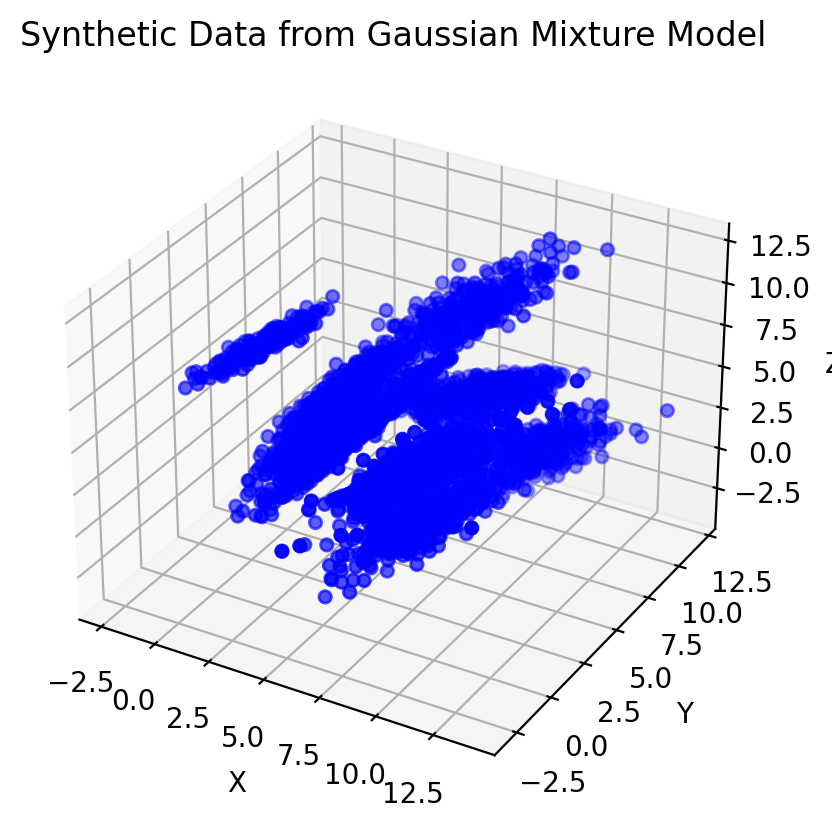

In [ ]:
num_samples = 5000
num_components = 10
dimension = 3
synthetic_data, means, covariances = generate_gaussian_mixture_data(num_samples, num_components, dimension)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(synthetic_data[:, 0], synthetic_data[:, 1], synthetic_data[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Synthetic Data from Gaussian Mixture Model')
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


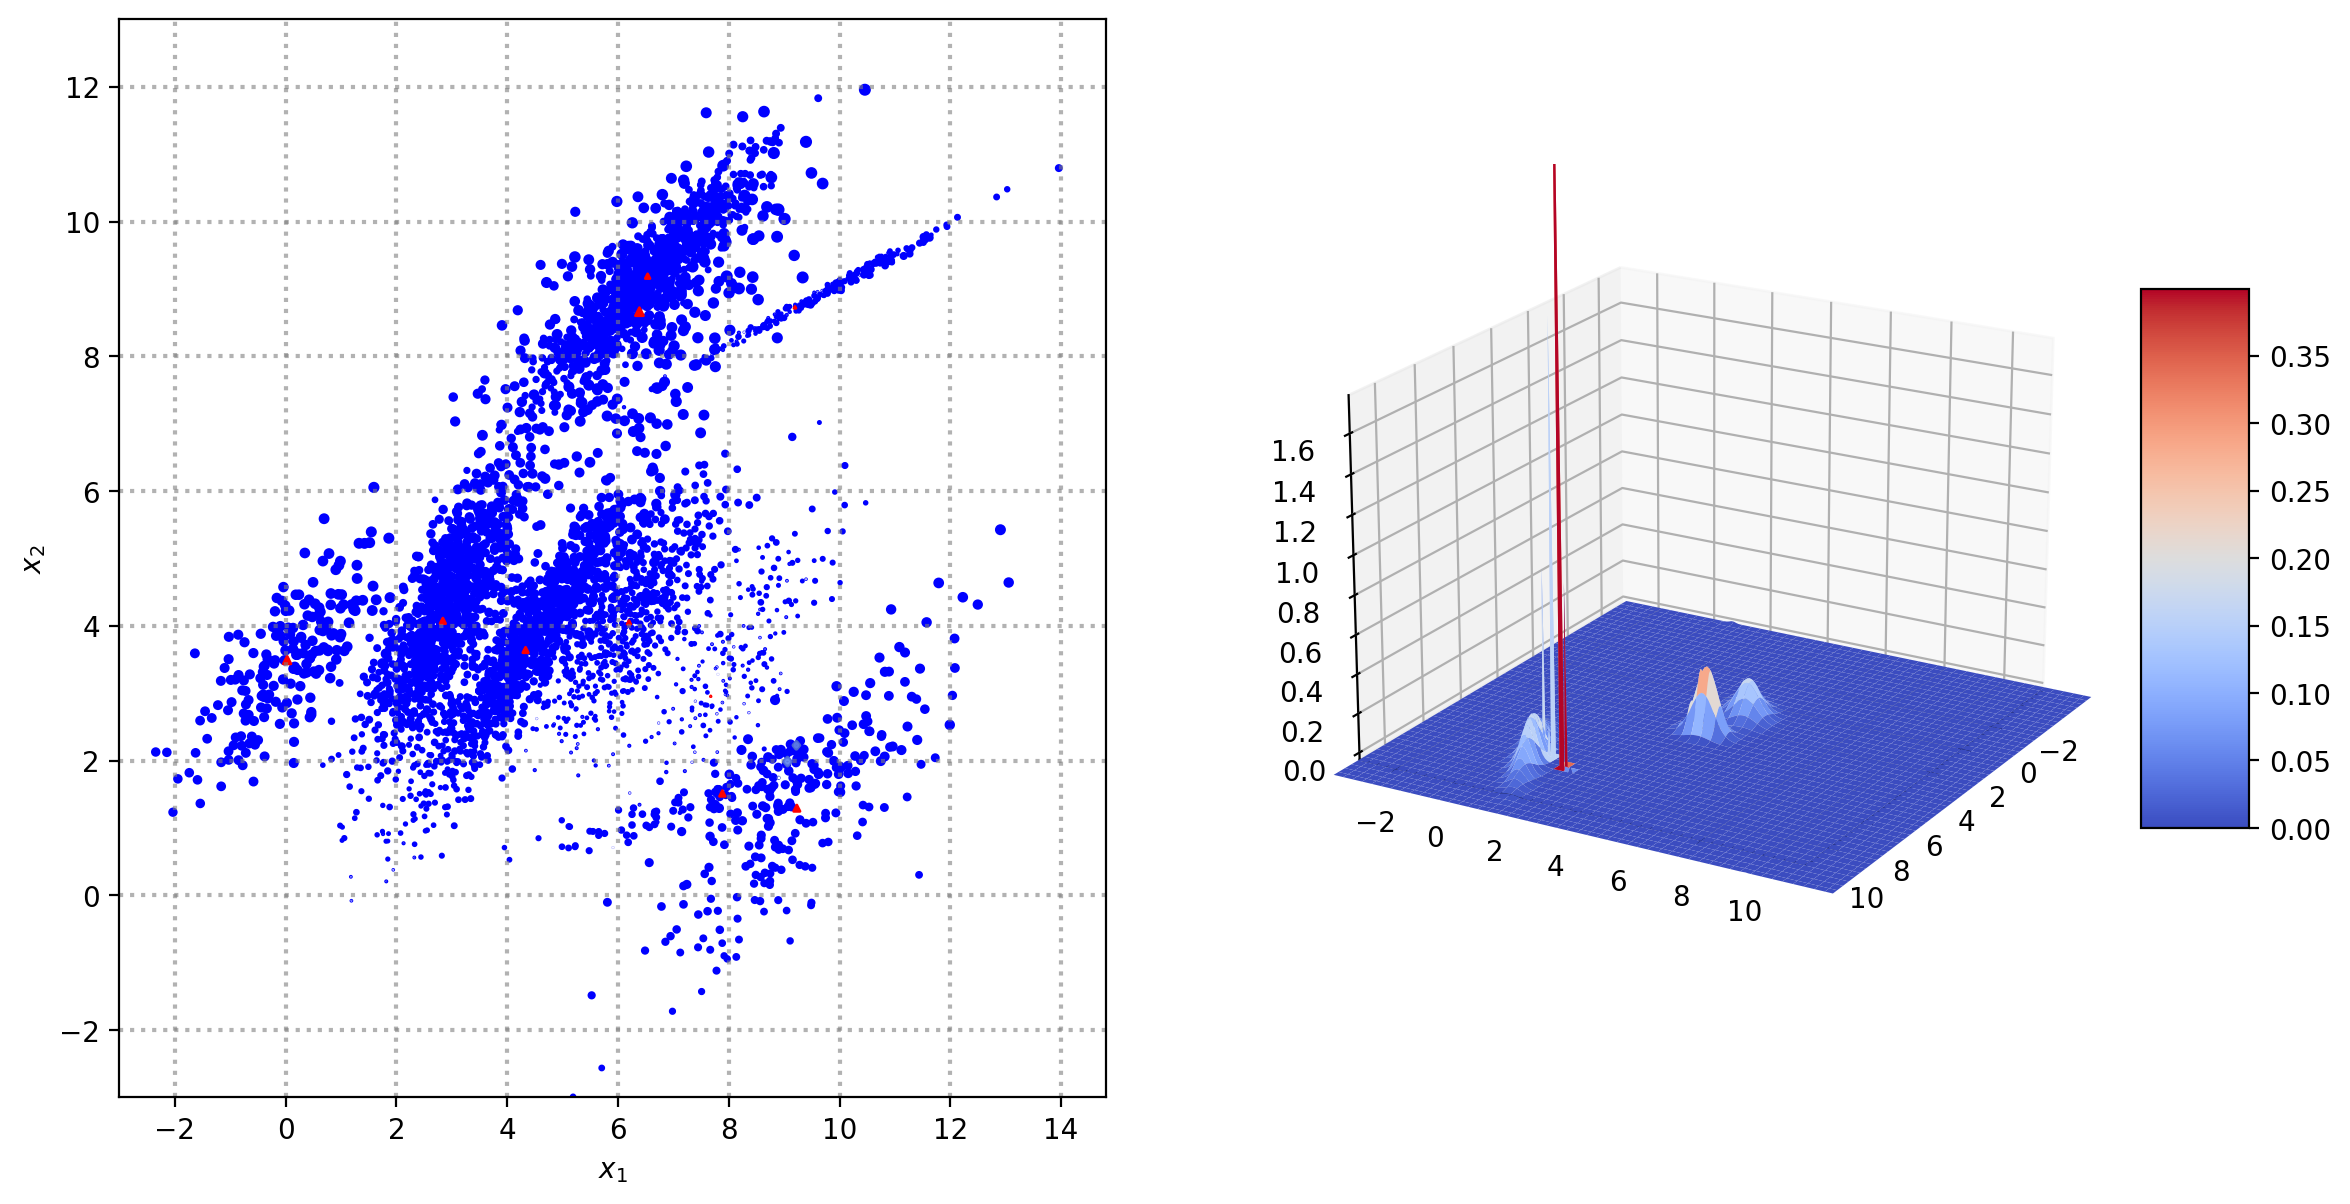

In [ ]:
# Define intervals for grid
intervals = 200

# Define the grid
x = np.linspace(-3, 13, intervals)
y = np.linspace(-3, 13, intervals)
z = np.linspace(-3, 13, intervals)

X, Y, Z = np.meshgrid(x, y, z)

xys = np.vstack([X.ravel(), Y.ravel(), Z.ravel()]).T

# Evaluate p(x) for each point of the grid
K = 10  # Number of components in the Gaussian Mixture Model
Zgmm = np.zeros(len(xys))
for k in range(K):
    Zgmm += mvn.pdf(xys, mean=means[k], cov=covariances[k])  # Adjusted to use the means and covariances from your data

# Reshape Zgmm for contour plot
Zgmm = Zgmm.reshape([intervals, intervals, intervals])

# Plot contour plot
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 2, 1)

# Plot contours
contour_levels = np.linspace(Zgmm.min(), Zgmm.max(), 20)
ax.contour(X[:, :, 0], Y[:, :, 0], Zgmm[:, :, int(intervals / 2)], contour_levels, cmap=cm.coolwarm)

# Scatter plot of synthetic data
ax.scatter(synthetic_data[:, 0], synthetic_data[:, 1], synthetic_data[:, 2], c='b')


# Scatter plot of means
ax.scatter(means[:, 0], means[:, 1], means[:, 2],marker='^', color='red')

ax.grid(which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)


ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

# Plot 3D surface

ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(X[:, :, 0], Y[:, :, 0], Zgmm[:, :, int(intervals / 2)], cmap=cm.coolwarm)

# Adjust the viewing angle
ax.view_init(elev=20, azim=30)

# Adjust the limits of the axes for zooming
ax.set_xlim([-3, 11])
ax.set_ylim([-3, 11])
ax.set_zlim([0, 1.75])

# Add grid
ax.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dotted', lw=1.5)

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()


Train Epoch: 0 	Loss: 21.683346
Train Epoch: 1 	Loss: 21.103921
Train Epoch: 2 	Loss: 21.103776
Train Epoch: 3 	Loss: 21.103749
Train Epoch: 4 	Loss: 21.103746
Train Epoch: 5 	Loss: 21.103775
Train Epoch: 6 	Loss: 21.103770
Train Epoch: 7 	Loss: 21.103737
Train Epoch: 8 	Loss: 21.103782
Train Epoch: 9 	Loss: 21.103792


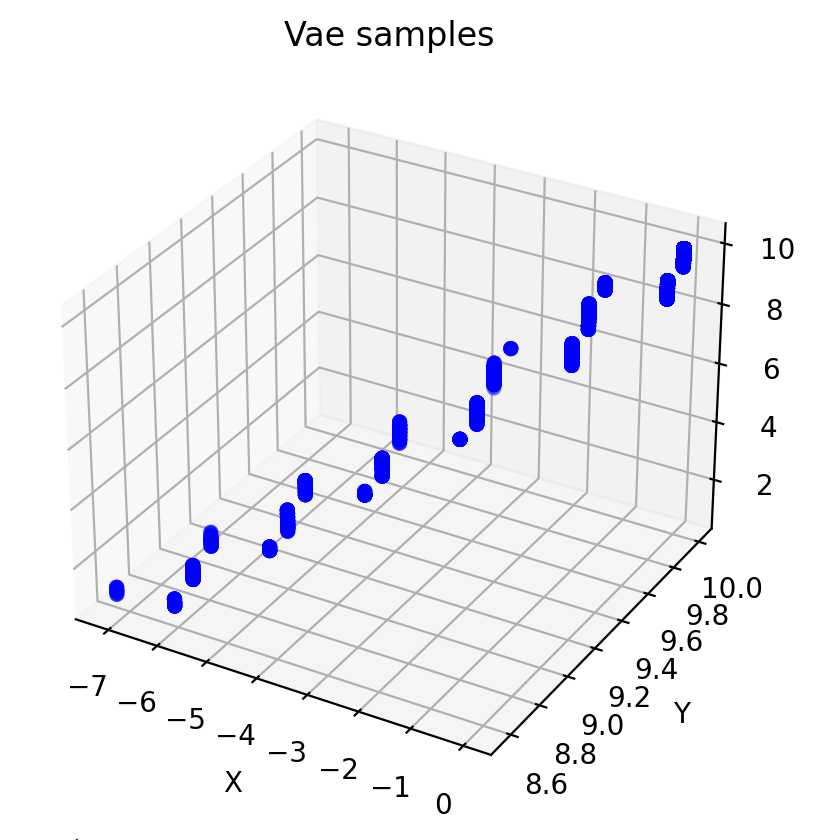

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Number of clusters in VAE-generated samples: 2
Number of clusters in ground truth data: 4
Number of modes in VAE-generated samples: 5
Number of modes in ground truth data: 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
data_tensor = torch.tensor(synthetic_data, dtype=torch.float32)

# Initialize VAE
latent_dim = 2  # Define latent dimension
vae = VAE_extended(dimz=latent_dim, input_dim=dimension)

# Train VAE
vae.trainloop(data_tensor, batch_size=32)

# generate VAE samples
vae_samples = vae.sample(num_samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vae_samples[:, 0], vae_samples[:, 1], vae_samples[:, 2], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Vae samples')
plt.show()

# Compare clusters
num_clusters_ground_truth = vae.compare_clusters(data_tensor)
num_clusters_ground = vae.compare_clusters(vae_samples)

print(f"Number of clusters in VAE-generated samples: {num_clusters_vae}")
print(f"Number of clusters in ground truth data: {num_clusters_ground}")

from scipy.signal import find_peaks

def identify_modes(data, threshold=0.1, distance=10):
    density, _ = np.histogram(data, bins=50, density=True)
    peaks, _ = find_peaks(density, height=threshold, distance=distance)
    modes = len(peaks)
    return modes

modes_syn = identify_modes(data_tensor)
modes_vae = identify_modes(vae_samples)

print(f"Number of modes in VAE-generated samples: {modes_vae}")
print(f"Number of modes in ground truth data: {modes_syn}")

In [ ]:
from sklearn.manifold import TSNE

x = torch.tensor(synthetic_data, dtype=torch.float32)

z_batch,_,_ = vae.encoder.encode_and_sample(x)


latent_tsne = TSNE(n_components=2, perplexity=15).fit_transform(z_batch.detach().numpy())

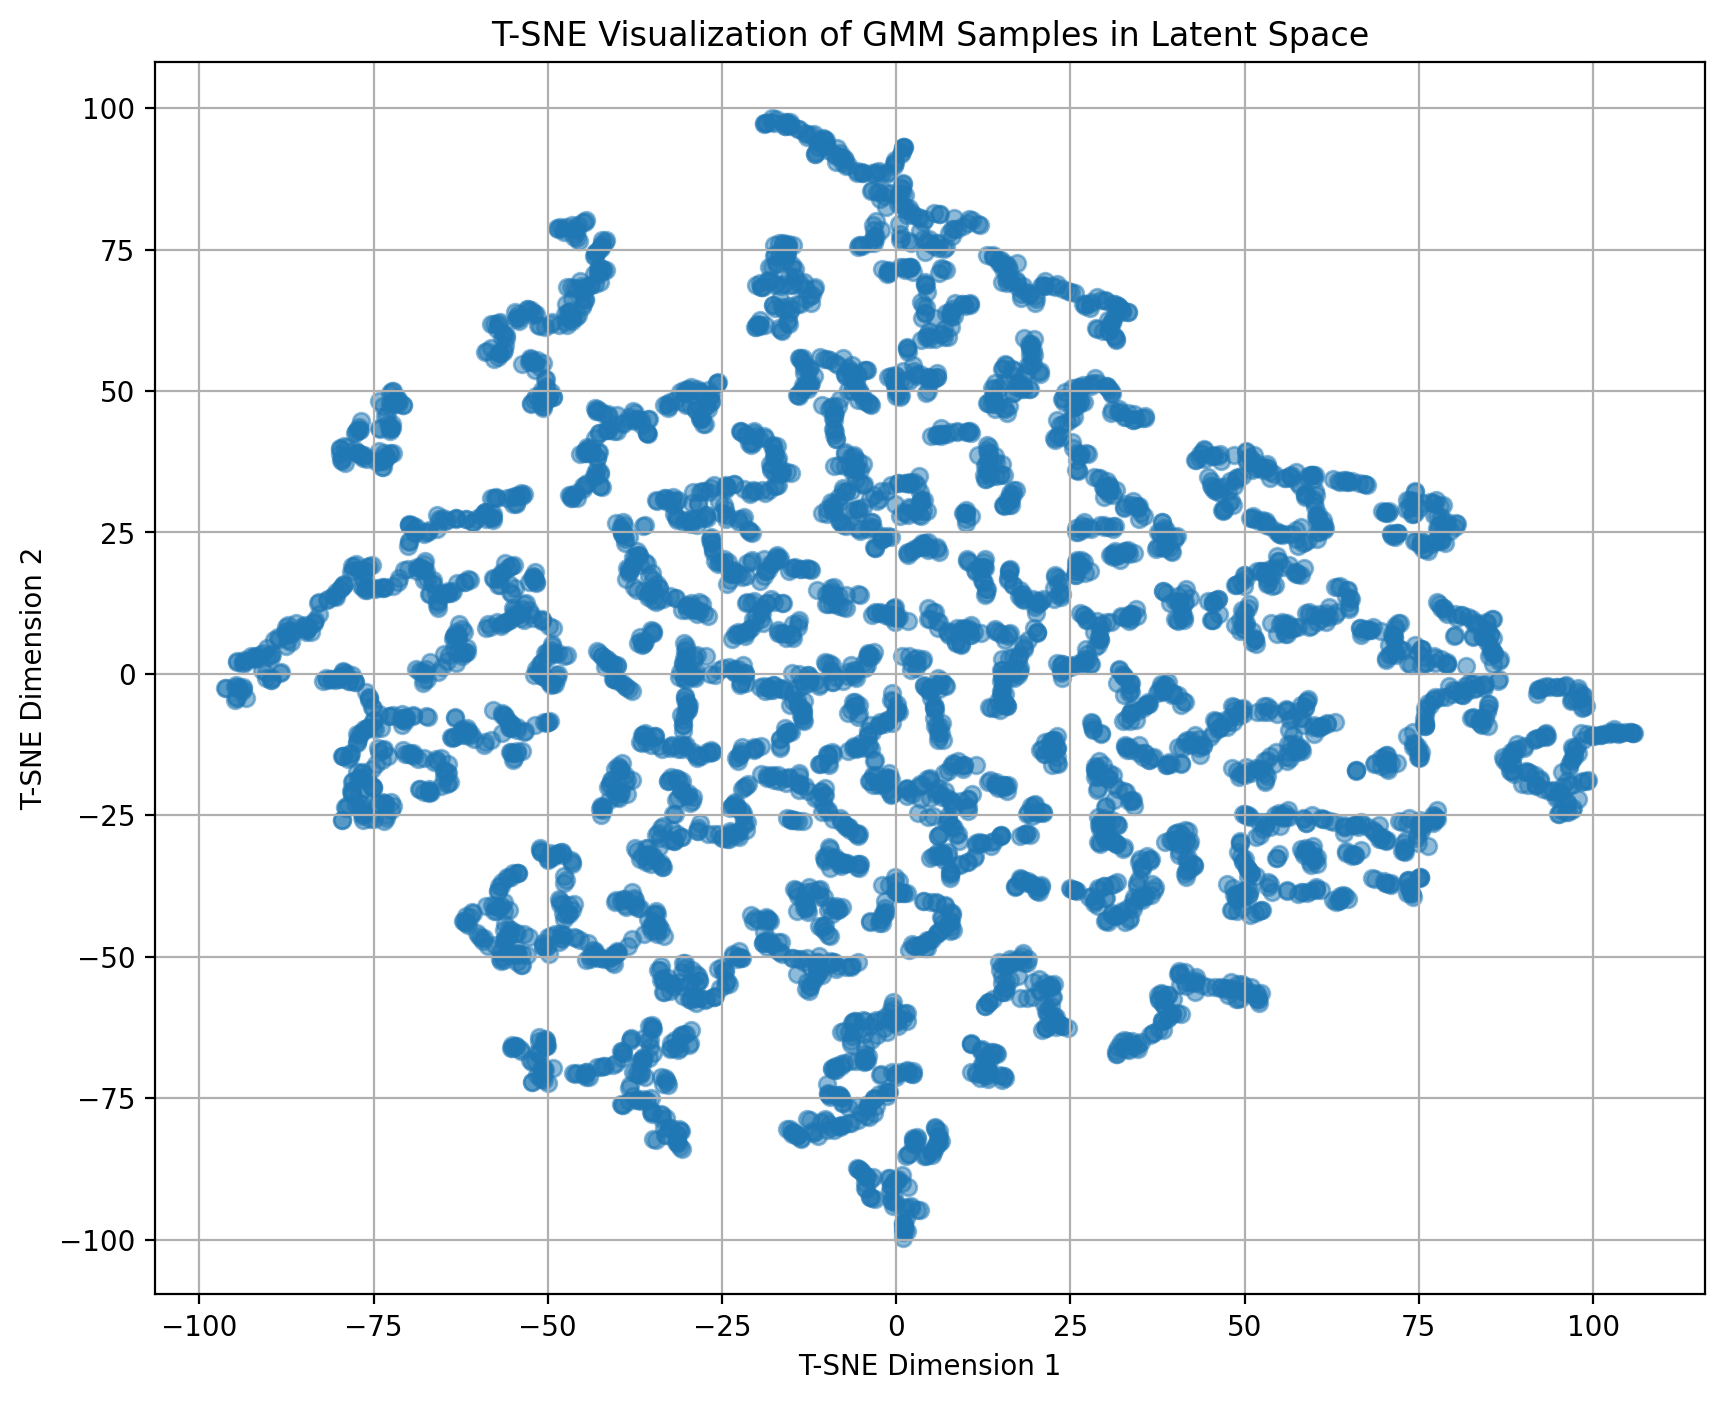

In [ ]:
# Plot T-SNE visualization
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5)
plt.title('T-SNE Visualization of GMM Samples in Latent Space')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.grid(True)
plt.show()